# Fiddling about with DR5 results (a bit) [v1.0]

In [60]:
%matplotlib notebook

In [94]:
# imports
import numpy as np
import pdb, imp

import matplotlib as mpl
mpl.rcParams['font.family'] = 'stixgeneral'
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

from astropy.coordinates import SkyCoord, match_coordinates_sky
from linetools import utils as ltu

from specdb.specdb import IgmSpec
from pyigm.surveys.dlasurvey import DLASurvey
from pyigm.surveys import utils as pyis_u

sys.path.append(os.path.abspath("../../src"))
import vette_results as vetter

## Read JSON file

In [2]:
result_file = '../../results/dr5_v2_results.json'
ml_dr5 = ltu.loadjson(result_file)

In [3]:
len(ml_dr5)

7478

In [4]:
ml_dr5[0]

{u'classification': u'NO_DLA',
 u'classification_confidence': 96,
 u'dec': -0.6870119571685791,
 u'dlas': [],
 u'fiber': 5,
 u'mjd': 0,
 u'num_dlas': 0,
 u'plate': 266,
 u'ra': 146.93861389160156,
 u'z_qso': 2.8328399658203125}

In [5]:
ml_dr5[2]

{u'classification': u'NO_DLA',
 u'classification_confidence': 93,
 u'dec': -0.9712327122688293,
 u'dlas': [{u'column_density': 20.562389373779297,
   u'dla_confidence': 0.3738497495651245,
   u'rest': 927.2055053710938,
   u'spectrum': 3836.1885852687556,
   u'std_column_density': 0.25730183720588684,
   u'z_dla': 2.1556167259772434}],
 u'fiber': 254,
 u'mjd': 0,
 u'num_dlas': 1,
 u'plate': 270,
 u'ra': 152.23239135742188,
 u'z_qso': 3.1373660564422607}

In [6]:
ml_dr5[5]

{u'classification': u'HAS_DLA',
 u'classification_confidence': 97,
 u'dec': 0.33888769149780273,
 u'dlas': [{u'column_density': 20.36636734008789,
   u'dla_confidence': 0.8868335485458374,
   u'rest': 985.9659423828125,
   u'spectrum': 5337.033751430688,
   u'std_column_density': 0.643308162689209,
   u'z_dla': 3.3901994385241787},
  {u'column_density': 20.48378562927246,
   u'dla_confidence': 0.8954387307167053,
   u'rest': 1082.8338623046875,
   u'spectrum': 5861.379812314408,
   u'std_column_density': 0.1063832938671112,
   u'z_dla': 3.8215221337323513},
  {u'column_density': 20.322036743164062,
   u'dla_confidence': 0.795092761516571,
   u'rest': 1165.3651123046875,
   u'spectrum': 6308.121477379696,
   u'std_column_density': 0.0018673656741157174,
   u'z_dla': 4.189008100372384},
  {u'column_density': 20.362953186035156,
   u'dla_confidence': 0.28717735409736633,
   u'rest': 1107.5467529296875,
   u'spectrum': 5995.150691907154,
   u'std_column_density': 0.09028507024049759,
   u'

## Load up DR5

In [7]:
sdssdr5 = DLASurvey.load_SDSS_DR5()

SDSS-DR5: Loading DLA file /Users/xavier/local/Python/pyigm/pyigm/data/DLA/SDSS_DR5/dr5_alldla.fits.gz
SDSS-DR5: Loading QSOs file /Users/xavier/local/Python/pyigm/pyigm/data/DLA/SDSS_DR5/dr5_dlagz_s2n4.fits
SDSS-DR5: Performing stats
SDSS-DR5: Loaded


In [8]:
sdssdr5.sightlines[0:4]

PLATE,FIB,RA,DEC,FLG_BAL,IQSO,MAG,S2N,Z_START,Z_END,ZEM,DX
,,deg,deg,,,,,,,,
int32,int32,float64,float64,int16,int32,float64,float64,float64,float64,float64,float64
266,5,146.93861,-0.68701194,1,0,19.341999054,4.94595003128,2.39664643878,2.74649000168,2.8287498951,1.17426266257
266,92,146.22601,-0.72509875,0,4,19.0820007324,8.54980564117,2.20000004768,2.25759506226,2.29049992561,0.184012498912
270,254,152.23239,-0.97123272,0,9,19.0230007172,7.49763822556,2.30636157714,3.0556242466,3.09659004211,2.56581152274
271,391,154.14992,0.14750838,0,16,18.0650005341,18.982629776,2.20000004768,2.25551605225,2.28839993477,0.177634457341


In [9]:
len(sdssdr5.sightlines), len(ml_dr5)

(7482, 7478)

### Setup coords

In [10]:
dla_coord = sdssdr5.coord

In [11]:
sl_coord = SkyCoord(ra=sdssdr5.sightlines['RA'], dec=sdssdr5.sightlines['DEC'])

In [12]:
idx, d2d, d3d = match_coordinates_sky(dla_coord, sl_coord, nthneighbor=1)

In [13]:
np.max(d2d.to('arcsec'))

<Angle 0.3689950092602071 arcsec>

### Specify HAS_DLA

In [14]:
sdssdr5.sightlines['HAS_ML'] = [False]*len(sdssdr5.sightlines)

In [15]:
jj = 0
for obj in ml_dr5:
    # Check plate fiber
    while ((obj['plate'] != sdssdr5.sightlines['PLATE'][jj]) or (obj['fiber'] != sdssdr5.sightlines['FIB'][jj])):
        print("Skipping plate={:d}, fiber={:d}".format(sdssdr5.sightlines['PLATE'][jj],sdssdr5.sightlines['FIB'][jj]))
        jj+=1
    # Machine learning
    if obj['classification'] == u'HAS_DLA':
        sdssdr5.sightlines['HAS_ML'][jj] = True
    jj+=1

Skipping plate=359, fiber=279
Skipping plate=1950, fiber=602
Skipping plate=1980, fiber=484
Skipping plate=2083, fiber=33


## Fraction of Hits

In [16]:
# Calculate fraction of HAS_DLA as a function of NHI
def chk_has_nhi(dlas, idx, NHI=20.3):
    # Cut on NHI
    gdD = dlas.NHI >= NHI
    # Dummy array
    jxp = np.array([False]*len(dlas.sightlines))
    # Sightline with DLA in it
    jxp[idx[gdD]] = True
    njxp = np.sum(jxp)
    # HAS?
    good = dlas.sightlines['HAS_ML'] & jxp
    ngood = np.sum(good)
    #pdb.set_trace()
    # Return
    return ngood, njxp

### NHI = 20.3

In [17]:
ngood, ntot = chk_has_nhi(sdssdr5, idx)
ngood, ntot

(629, 667)

### NHI = 21.

In [18]:
ngood21, ntot21 = chk_has_nhi(sdssdr5, idx, NHI=21.)
ngood21, ntot21

(121, 121)

In [19]:
629./667

0.9430284857571214

## Testing Module

### Load

In [114]:
reload(vetter)
ml_survey = vetter.json_to_sdss_dlasurvey(result_file, sdssdr5)

Loading SDSS Survey from JSON file ../../results/dr5_v2_results.json
Sightline RA=260.033 deg, DEC=52.5956 deg was not used
Sightline RA=153.781 deg, DEC=33.039 deg was not used
Sightline RA=165.409 deg, DEC=38.5598 deg was not used
Sightline RA=128.336 deg, DEC=20.6529 deg was not used


In [115]:
ml_survey

<IGMSurvey: nsys=7925, type=LLS, ref=, nsightlines=7478>

In [116]:
isys = ml_survey._abs_sys[0]
isys, isys.zem

(<LLSSystem: 10:08:55.7739 -00:58:16.4378, zabs=2.15562, logNHI=20.5624, tau_LL=2314.31, [Z/H]=0 dex>,
 3.1373660564422607)

### Write? -- This only writes the sytems and not the sightlines

In [23]:
#ml_survey.write_survey('dr5_v2.tar')

Wrote: dr5_v2.tar


In [27]:
# Read
#pyis_u.load_sys_files('../../results/dr5_v2.tar', 'LLS')

Loading systems from ../../results/dr5_v2.tar
Skipping a likely folder: IGM_JSON


<IGMSurvey: nsys=7762, type=LLS, ref=None>

### Vette

In [117]:
reload(vetter)
fneg, midx = vetter.vette_dlasurvey(ml_survey, sdssdr5)

Done cutting on Lyb


In [118]:
len(fneg)

100

In [119]:
len(tmp), np.sum(sdssdr5.mask)

(643, 643)

#### Compare Matches

<IPython.core.display.Javascript object>


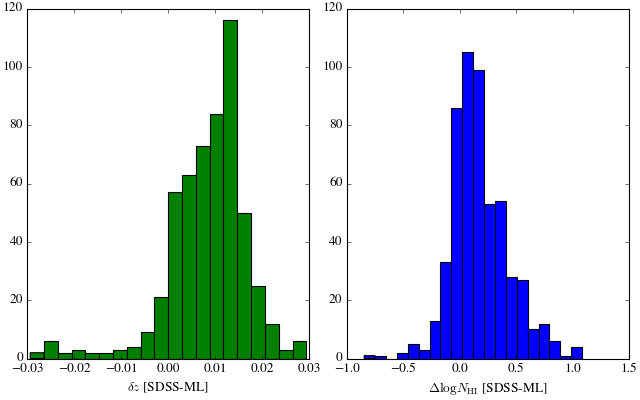

In [88]:
reload(vetter)
vetter.fig_dzdnhi(ml_survey, sdssdr5, midx, outfil=None)

#### False Negatives

<IPython.core.display.Javascript object>


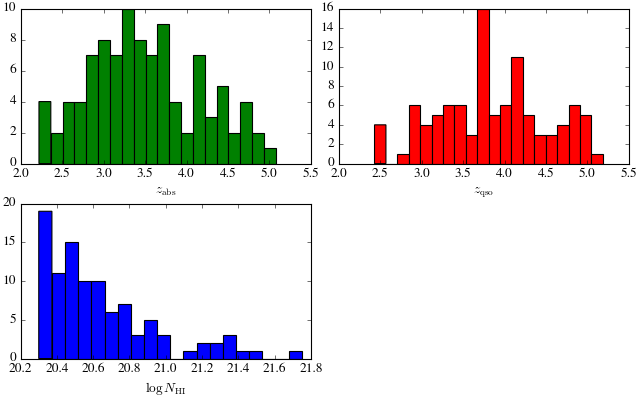

In [92]:
reload(vetter)
vetter.fig_falseneg(ml_survey, sdssdr5, fneg, outfil=None)

In [93]:
# Examining a high NHI system
NHI_false = np.array([isys.NHI for isys in fneg])
high_NHI = np.where(NHI_false > 21.)[0]
fneg[high_NHI[0]]

<DLASystem: 10:04:28.43 00:18:25.6, 2.685, NHI=21.35, Z/H=0>

In [101]:
igmsp = IgmSpec()
#igmsp.idb.hdf.close()

Using /raid/IGMSPEC_DB/IGMspec_DB_v02.hdf5 for the catalog file
Using /raid/IGMSPEC_DB/IGMspec_DB_v02.hdf5 for the DB file
Available surveys: [u'BOSS_DR12', u'HSTQSO', u'SDSS_DR7', u'KODIAQ_DR1', u'MUSoDLA', u'HD-LLS_DR1', u'2QZ', u'ESI_DLA', u'HDLA100', u'GGG', u'COS-Halos', u'HST_z2', u'COS-Dwarfs', u'XQ-100']
Database is igmspec
Created on 2016-Oct-25


In [106]:
# plot
spec, meta = igmsp.spec_from_coord(('10:04:28.43','00:18:25.6'), isurvey='SDSS_DR7')

Your search yielded 1 match[es]
Staged 1 spectra totalling 6.4e-05 Gb
Loaded spectra


<IPython.core.display.Javascript object>


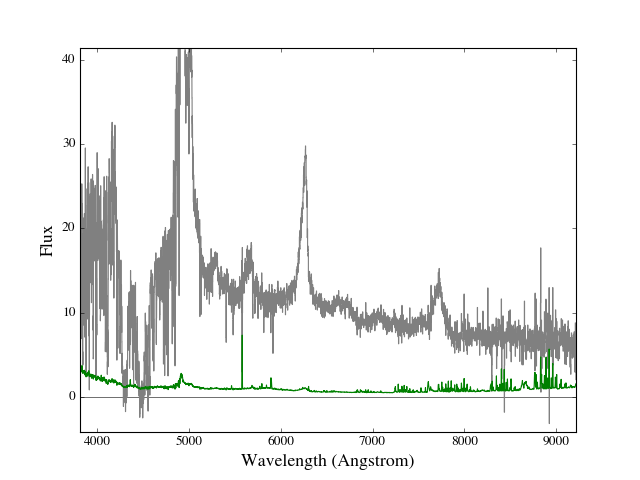

In [108]:
spec[0].plot()

In [112]:
meta[0]

SDSSJ,RA,DEC,zem,UMAG,UMAGERR,GMAG,GMAGERR,RMAG,RMAGERR,IMAG,IMAGERR,ZMAG,ZMAGERR,AU,logNH,FIRSTMAG,FIRSTSN,FIRSTDEL,RASSCNT,RASSSN,RASSDEL,JMAG,JMAGERR,HMAG,HMAGERR,KMAG,KMAGERR,MASSDEL,MASSFLG,MIMAG,DGMI,MFLAG,SPFLAG,MODEFLAG,USELFLAG,BESTFLAG,LZFLAG,HZFLAG,FTFLAG,RTFLAG,SRFLAG,STFLAG,GXFLAG,RUN,RMJD,SMJD,PLATE,FIBER,RERUN,CAMCOL,FIELD,OBJECT,TFLAG,LZTFLAG,HZTFLAG,FTTFLAG,RTTFLAG,SRTFLAG,STTFLAG,GXTFLAG,UTMAG,UTMAGERR,GTMAG,GTMAGERR,RTMAG,RTMAGERR,ITMAG,ITMAGERR,ZTMAG,ZTMAGERR,BESTID,SPECOID,ONAME,DATE-OBS,EPOCH,R,sig_zem,IGM_ID,SPEC_FILE,NPIX,WV_MIN,WV_MAX,SURVEY_ID,INSTR,GRATING,TELESCOPE,flag_zem
str31,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str31,str31,str31,str10,float64,float64,float64,int64,str28,int64,float64,float64,int64,str4,str4,str10,str10
100428.43+001825.6,151.118469,0.307132,3.05440402031,20.421,0.047,18.601,0.018,18.49,0.013,18.494,0.015,18.406,0.036,0.172,20.467,0.0,0.0,0.0,-9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-27.882,-0.186,0,1,1,0,3,1,1,0,0,0,0,0,756,51259,51910,269,467,44,4,236,203,4,1,0,0,0,0,0,0,20.369,0.044,18.593,0.006,18.504,0.007,18.497,0.008,18.391,0.028,588848900436918475,75939722446241792,SDSS J100428.43+001825.6,2001-01-01,2000.0,2000.0,0.0,328797,spSpec-51910-0269-467.fit.gz,3834,3812.41351104,9215.09888735,34360,SDSS,BOTH,SDSS 2.5-M,SDSS-HW


### Table for David (false negatives)

In [121]:
ra  = []
dec = []
zabs = []
zem = []
NHI = []
for ifneg in fneg:
    ra.append(ifneg.coord.ra.value)
    dec.append(ifneg.coord.dec.value)
    zabs.append(ifneg.zabs)
    zem.append(ifneg.zem)
    NHI.append(ifneg.NHI)

In [123]:
fneg_tbl = Table()
fneg_tbl['RA'] = ra
fneg_tbl['DEC'] = dec
fneg_tbl['zabs'] = zabs
fneg_tbl['zem'] = zem
fneg_tbl['NHI'] = NHI

In [124]:
fneg_tbl[0:3]

RA,DEC,zabs,zem,NHI
float64,float64,float64,float32,float64
116.251958333,34.2919722222,2.99463,3.71,20.3
145.035166667,2.53586111111,2.56537,3.22,20.7
151.118458333,0.307111111111,2.53997,3.05,21.0


In [126]:
fneg_tbl.write('../../results/false_negative_DR5.csv', format='ascii.csv')